## Practical part: Density estimation

In [2]:
import numpy as np
from numpy import pi, exp, log
import matplotlib.pyplot as plt

### Load iris dataset

In [3]:
# sepal_length,sepal_width,petal_length,petal_width,species
iris_data = np.loadtxt("iris.txt")
iris_features = iris_data[:, 0:4] 
species = iris_data[:,-1]

## Question 1
Implement a diagonal Gaussian parametric density estimator. It will
have to work for data of arbitrary dimension d. As seen in the labs, it
should have a train() method to learn the parameters and a method
predict() which calculates the log density.

In [27]:
class Gaussian:
    
    def __init__(self):
        self.d = 0
        self.mu = 0
        # sigma is the covariance matrix
        # not the square of the variance
        self.sigma = 1
        
    def reshape_inputs(self, X):
        """Add a dummy dimension to Xif X have 1 dimension"""
        try:
            n, d = X.shape
        except ValueError:
            n = X.shape[0]
            X = X.reshape(n, 1)
        return X
    
    def inv(self, a): return np.linalg.inv(a)
    
    def det(self, a): return np.linalg.det(a)
    
    def gaussian(self, x, log_density=True):
        Z = (2 * pi * self.sigma)**(1 / 2)
        y = - 0.5 * (x-self.mu)**2/self.sigma
        
        if log_density:
            return -log(Z) * y
        else:
            return exp(y) / Z
    
    def multi_gaussian(self, x, log_density=True):
        Z = (2 * pi)**(self.d / 2) * self.det(self.sigma)**(1 / 2)
        y = -0.5 * (x - self.mu).dot(self.inv(self.sigma)).dot((x - self.mu).T)
        
        if log_density:
            return -log(Z) * y 
        else:
            return exp(y) / Z
        
    def train(self, X):
        """Fit a diagonal parametric gaussian using log-likelihood
        
        Args:
            X: (array or ndarray) inputs of size <n x 1> or <n x d> 
        
        return: (mu, sigma)
        
        NOTE: the covariance matrix is multiply by an identity
        matrix to ensure that non diag]onal element are equal to ]
        zero
        """
        X = self.reshape_inputs(X)
        n, self.d = X.shape
        
        self.mu = np.sum(X, axis=0).reshape(1, self.d)/n
        self.sigma = np.dot(X.T-self.mu.T, X-self.mu)/(n-1) * np.eye(self.d)
        
        return self.mu, self.sigma
    
    def predict(self, X, log_density=True):
        
        n = X.shape[0]
        
        if self.d == 1:
            return self.gaussian(X, log_density).reshape(n,)
        else:
            return np.array([self.multi_gaussian(x, log_density) for x in X]).reshape(n,)

In [28]:
X = iris_features[:,0:2]
gaussian = Gaussian()
gaussian.train(X)
prob = gaussian.predict(X)
print(prob.shape)

(150,)


## Question 2
Implement a Parzen density estimator with an isotropic Gaussian kernel. It will have to work for data of arbitrary dimension d. Likewise it should have a train() method and a predict() method that computes the log density.

In [78]:
class Parzen:
    """
    Args:
        data: the data to be fit
        var: the square of the bandwidth. either silverman, None, or a float. If window is set to None, 
        the bandwidth is set to the enpirical standard deviation
    """
    def __init__(self, data, var=None):
        self.data = data
        self.d = 0
        self.var = var
        
    def reshape_inputs(self, X):
        """Add a dummy dimension to X if X have 1 dimension"""
        try:
            n, d = X.shape
        except ValueError:
            n = X.shape[0]
            X = X.reshape(n, 1)
        return X
    
    def gaussian(self, x, mu):
        Z = (2 * pi * self.var)**(self.d / 2)
        if self.d == 1:
            dist = (x - mu)**2
        else:
            dist = (x - mu).dot((x-mu).T) 
        y = -0.5 * dist / self.var

        return exp(y) / Z
        
    def train(self):
        """
        
        """
        X = self.reshape_inputs(self.data)
        n, self.d = X.shape
        mu = np.sum(X, axis=0).reshape(1, self.d)/n
        
        if self.var == 'silverman':
        
            cov = np.mean(np.diag(np.dot(X.T-mu.T, X-mu)/(n-1) * np.eye(self.d)))
            
            self.var = ((4 * cov**2.5) / (3*n))**(1 / 5)
            
        elif self.var is None:
            
            cov = np.mean(np.diag(np.dot(X.T-mu.T, X-mu)/(n-1) * np.eye(self.d)))
            
            self.var = cov
    
    def predict(self, X, log_density=True):
        
        n = self.data.shape[0]
        if log_density:
            return np.array([log(sum([self.gaussian(xi, x) for xi in self.data]) / n) for x in X])
        else:
            return np.array([sum([self.gaussian(xi, x) for xi in self.data]) / n for x in X])

In [79]:
X = iris_features[:,0:2]
kde = Parzen(X)
kde.train()
prob = kde.predict(X)
print(prob.shape)

(150,)


## Question 3
1D densities: From the Iris dataset examples, choose a subset corresponding
to one of the classes (of your choice), and one of the characteristic
features, so that we will be in dimension $d$ = 1 and produce a
single graph (using the plot function) including:

In [82]:
class OneDimDensities:
    
    def __init__(self, inputs, gaussian):
        
        self.inputs = inputs
        self.gaussian = gaussian
        
        self.n = len(inputs)
        self.mu, self.sigma = gaussian.train(inputs)
        
        # plot parameters
        self.n_bins = 1000
        self.x_min = np.min(inputs)-1
        self.x_max = np.max(inputs)+1
        self.alpha=0.75
        
        self.legend = [
            'Parametric Gaussian', 
            'KDE small sigma',
            'KDE large sigma',
            'KDE appropriate sigma',
            'data points'
        ]
    
    def add_data_points(self):
        """Plot the data points of the inputs 
        (displayed on the x axis)"""
        plt.scatter(self.inputs, np.zeros(self.n), color='red')
    
    def add_gaussian_density(self):
        """Plot of the density estimated by 
        the parametric Gaussian estimator"""
        x = np.linspace(self.x_min, self.x_max, self.n_bins)
        prob = self.gaussian.predict(x, log_density=False)
        plt.plot(x, prob, color='black', alpha=self.alpha)
        
    def add_kde(self, sigma_size):
        """Plot the density estimated by the Parzen estimator with 
        a hyper-parameter σ (standard deviation) too small
        
        Args:
            sigma_size: either small, big or normal
        """
        X = np.linspace(self.x_min, self.x_max, self.n_bins)
        if sigma_size == 'small':
            kde = Parzen(self.inputs, var=0.001)
            color = 'green'
        elif sigma_size == 'big':
            kde = Parzen(self.inputs, var=5)
            color = 'blue'
        elif sigma_size == 'normal':
            kde = Parzen(self.inputs)
            color = 'orange'
        kde.train()
        prob = kde.predict(X, log_density=False)
        plt.plot(X, prob, color, alpha=self.alpha)
    
    def add_legend(self):
        plt.legend(self.legend)
    
    def run(self):
        plt.figure()
        self.add_data_points()
        self.add_gaussian_density()
        self.add_kde('small')
        self.add_kde('big')
        self.add_kde('normal')
        self.add_legend()
        plt.show()

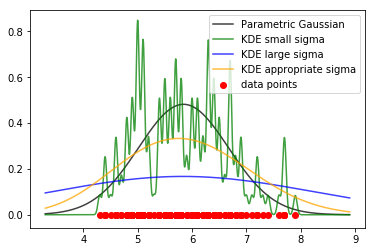

In [83]:
sepal_length = iris_features[:,0]
gaussian = Gaussian()
plot = OneDimDensities(sepal_length, gaussian)
plot.run()

## Question 4

In [85]:
class TwoDimDensities:
    
    def __init__(self, inputs, gaussian):
        
        self.inputs = inputs
        self.gaussian = gaussian
        
        self.n = len(inputs)
        gaussian.train(inputs)
        
        # plot parameters
        self.n_bins = 40
        self.x_min = np.min(inputs[:,0])-0.5
        self.x_max = np.max(inputs[:,0])+0.5
        self.y_min = np.min(inputs[:,1])-0.5
        self.y_max = np.max(inputs[:,1])+0.5
        self.alpha = 0.75
        
        self.legend = [
            'Parametric Gaussian', 
            'KDE small sigma',
            'KDE large sigma',
            'KDE appropriate sigma',
            'data points'
        ]
    
    def add_data_points(self):
        """Plot the data points of the inputs 
        (displayed on the x axis)"""
        plt.scatter(self.inputs[:,0], self.inputs[:,1], color='red')
        
    def grid_space(self):
        X = np.linspace(self.x_min, self.x_max, self.n_bins)
        Y = np.linspace(self.y_min, self.y_max, self.n_bins)
        n = len(X) * len(Y)
        inputs = np.zeros([n, 2])
        i = 0
        for x in X:
            for y in Y:
                inputs[i, 0] = x
                inputs[i, 1] = y
                i += 1
        return X, Y, inputs
    
    def add_gaussian_density(self):
        x, y, xy = self.grid_space()
        X, Y = np.meshgrid(x, y)
        prob = self.gaussian.predict(xy, log_density=False).reshape(self.n_bins, self.n_bins)
        plt.contour(X, Y, prob)
    
    def add_parzen_density(self, var):
        x, y, xy = self.grid_space()
        X, Y = np.meshgrid(x, y)
        kde = Parzen(self.inputs, var)
        kde.train()
        prob = kde.predict(xy, log_density=False).reshape(self.n_bins, self.n_bins)
        plt.contour(X, Y, prob)
    
    def gaussian_contour(self):
        plt.figure()
        self.add_data_points()
        self.add_gaussian_density()
        plt.show()
    
    def parzen_contour(self, var=None):
        plt.figure()
        self.add_data_points()
        self.add_parzen_density(var)
        plt.show()

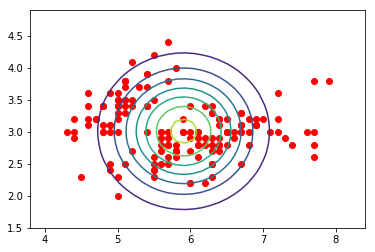

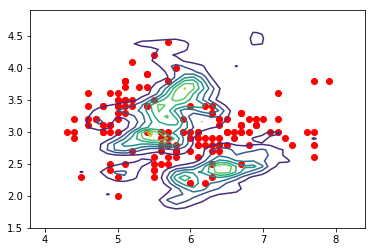

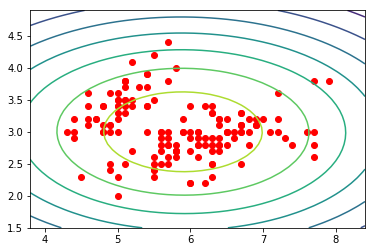

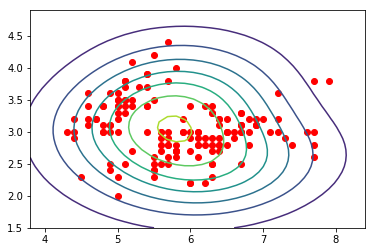

In [86]:
X = iris_features[:,0:2]
gaussian = Gaussian()
plot = TwoDimDensities(X, gaussian)
plot.gaussian_contour()
plot.parzen_contour(0.01)
plot.parzen_contour(5)
plot.parzen_contour()